In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from create_data import DataCreator
from lstm import LSTMRegressor
from sklearn import set_config
set_config(transform_output = "pandas")
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


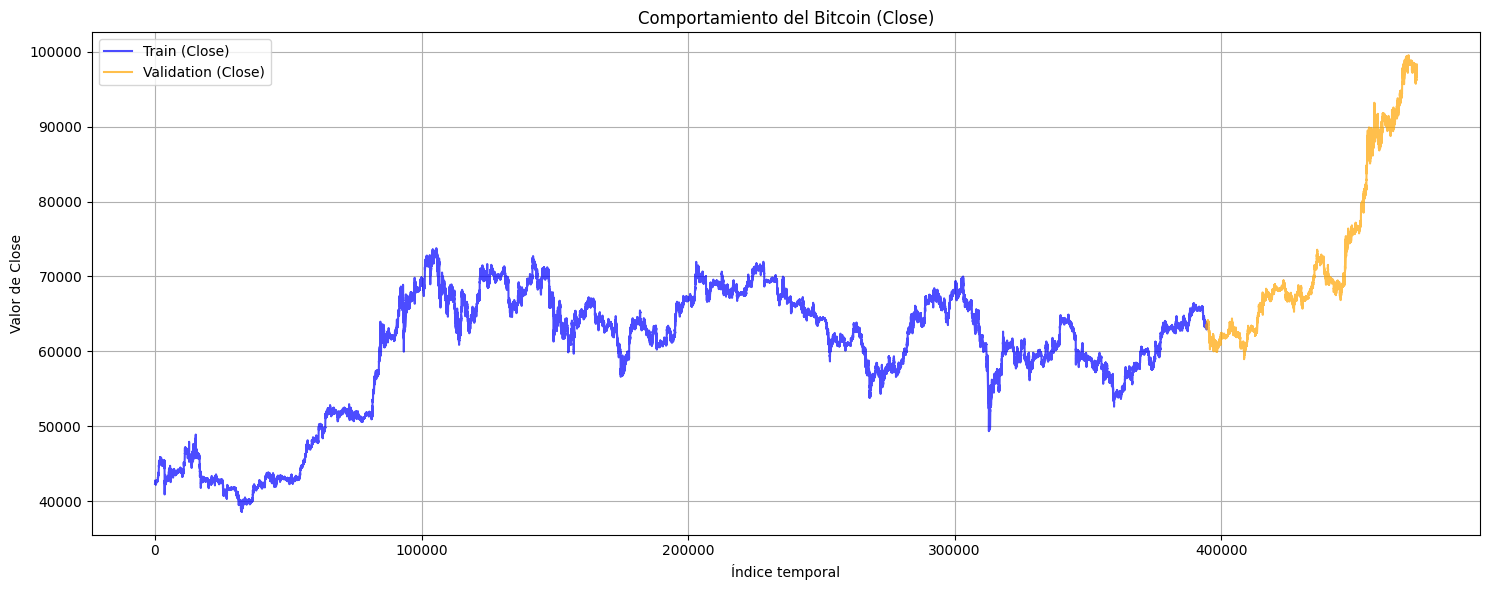

In [28]:
path = "Binance_BTCUSDT_2024_minute.csv"
date_cols = ["Date"]
cols_to_drop = ["Unix","Symbol","Volume BTC","Volume USDT"]

data = DataCreator(path = path, date_cols = date_cols, cols_to_drop = cols_to_drop)
train_sequences, val_sequences = data.run(month = 9, seq_len = 120, tc = "Close", plot = True) 


In [29]:
x = torch.randint(1, 100, (1, 3, 11), dtype = torch.float)
lstm = LSTMRegressor(input_size = 11, hidden_size = 2, n_layers=2)


In [30]:
lstm.eval()
with torch.no_grad():
    y_pred = lstm(x).cpu().numpy()

data.inverse_scale(y_pred)

AttributeError: 'LSTMRegressor' object has no attribute '_modules'